In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR, SVC
from sklearn.linear_model import LinearRegression as LR 
from scipy import stats

In [2]:
DF = pd.read_csv("dataset_world_happiness.csv")
DF

,Country,Region,Happiness Rank,Happiness Score,GDP Per Capita,Family,Health (Life Expectancy),Freedom,Trust (Government Corruption),Generosity,Dystopia Residual,Year
0,Switzerland,Western Europe,1,7.587,1.39651,1.34951,0.94143,0.66557,0.41978,0.29678,2.51738,2015
1,Iceland,Western Europe,2,7.561,1.30232,1.40223,0.94784,0.62877,0.14145,0.43630,2.70201,2015
2,Denmark,Western Europe,3,7.527,1.32548,1.36058,0.87464,0.64938,0.48357,0.34139,2.49204,2015
3,Norway,Western Europe,4,7.522,1.45900,1.33095,0.88521,0.66973,0.36503,0.34699,2.46531,2015
4,Canada,North America,5,7.427,1.32629,1.32261,0.90563,0.63297,0.32957,0.45811,2.45176,2015
...,...,...,...,...,...,...,...,...,...,...,...,...
754,NaN,Rwanda,152,3.334,0.35900,NaN,0.61400,0.55500,0.41100,0.21700,NaN,2019
755,NaN,Tanzania,153,3.231,0.47600,NaN,0.49900,0.41700,0.14700,0.27600,NaN,2019
756,NaN,Afghanistan,154,3.203,0.35000,NaN,0.36100,0.00000,0.02500,0.15800,NaN,2019
757,NaN,Central African Republic,155,3.083,0.02600,NaN,0.10500,0.22500,0.03500,0.23500,NaN,2019


In [3]:

### cleaning data set

#*********** Cleaning Country Column ***********#
mask = DF.Country.isnull()                       # Gets index of where "Country" is null == mask
DF.loc[mask, 'Country'] = DF.loc[mask,'Region']  # Inserts the value in "Region" at the same index into "Country"   

idx = DF.Country == DF.Region   # Finds index of where "Region" == "Country"
DF.loc[idx,'Region'] = np.nan   # Replaces "Region" with NaN


#************ Cleaning Region Column *************#
for i in range(len(DF['Region'])):
    
    if pd.isnull(DF.loc[i,'Region']):   # Locating cell of Null values for Region 
        country = DF.loc[i,'Country']   # stores Country of postion i 
        
        for x in range(len(DF['Country'])):
            # going through DF['Country'] until we find 'country' value and if Region is not null 
            if DF.loc[x,'Country'] == country and pd.notnull(DF.loc[x,'Region']):
                DF.loc[i,'Region'] = DF.loc[x,'Region']  # Storing Region value from postion x into position i
                break     # Breaking out of loop / ASK TA
                
indexNullRegion = DF[DF['Region'].isnull()].index.to_numpy()
NullRegion_values = ['Southeastern Asia','Eastern Asia','Sub-Saharan Africa','Latin America and Caribbean',
                    'Middle East and Northern Africa','Sub-Saharan Africa','Latin America and Caribbean',
                    'Middle East and Northern Africa','Central and Eastern Europe','Middle East and Northern Africa',
                    'Sub-Saharan Africa']
counter=0;
for i in indexNullRegion:
    if counter< 11:
        DF.loc[i,'Region'] = NullRegion_values[counter]
        counter+=1
        
#************ Cleaning Family Column ************# 

# mean for close values ; median for outliers 

RegionGrouped = DF.groupby('Region')['Family'].mean() 
# m = DF.groupby('Region')['Family'].median()
indexNullFamily = DF[DF['Family'].isnull()].index.to_numpy()

for i in indexNullFamily:
    DF.loc[i,'Family'] = RegionGrouped[DF.loc[i,'Region']]
    
#*********** Cleaning Dystopia Residual ********#

indexNullDR = DF[DF['Dystopia Residual'].isnull()].index.to_numpy()
DRmean = DF['Dystopia Residual'].mean() 
DF.loc[indexNullDR,'Dystopia Residual'] = DRmean 

#***********Trust (Government Corruption)*******#
Trustmean = DF["Trust (Government Corruption)"].mean()
indexNullTrust = DF[DF['Trust (Government Corruption)'].isnull()].index.to_numpy()
DF.loc[indexNullTrust,'Trust (Government Corruption)'] = Trustmean 

# #*************Droping Outliers********************#


#   GDP Per Capita outliers 
z= np.abs(stats.zscore(DF['GDP Per Capita']))
DF = DF[(z < 3)]

#   Family outliers 
z= np.abs(stats.zscore(DF['Family']))
DF = DF[(z < 3)]

#  Health (Life Expectancy) Outliers 
z= np.abs(stats.zscore(DF['Health (Life Expectancy)']))
DF = DF[(z < 3)]

#  Freedom Outliers 
z= np.abs(stats.zscore(DF['Freedom']))
DF = DF[(z < 3)]

#  Trust (Government Corruption) outliers 
z= np.abs(stats.zscore(DF['Trust (Government Corruption)']))
DF = DF[(z < 3)]

#   Generosity outliers 
z= np.abs(stats.zscore(DF['Generosity']))
DF = DF[(z < 3)]

#   Dystopia Residual outliers 
z= np.abs(stats.zscore(DF['Dystopia Residual']))
DF = DF[(z < 3)]

DF

,Country,Region,Happiness Rank,Happiness Score,GDP Per Capita,Family,Health (Life Expectancy),Freedom,Trust (Government Corruption),Generosity,Dystopia Residual,Year
0,Switzerland,Western Europe,1,7.587,1.39651,1.349510,0.94143,0.66557,0.41978,0.29678,2.517380,2015
1,Iceland,Western Europe,2,7.561,1.30232,1.402230,0.94784,0.62877,0.14145,0.43630,2.702010,2015
3,Norway,Western Europe,4,7.522,1.45900,1.330950,0.88521,0.66973,0.36503,0.34699,2.465310,2015
4,Canada,North America,5,7.427,1.32629,1.322610,0.90563,0.63297,0.32957,0.45811,2.451760,2015
5,Finland,Western Europe,6,7.406,1.29025,1.318260,0.88911,0.64169,0.41372,0.23351,2.619550,2015
...,...,...,...,...,...,...,...,...,...,...,...,...
754,Rwanda,Sub-Saharan Africa,152,3.334,0.35900,0.791847,0.61400,0.55500,0.41100,0.21700,2.092243,2019
755,Tanzania,Sub-Saharan Africa,153,3.231,0.47600,0.791847,0.49900,0.41700,0.14700,0.27600,2.092243,2019
756,Afghanistan,Southern Asia,154,3.203,0.35000,0.685964,0.36100,0.00000,0.02500,0.15800,2.092243,2019
757,Central African Republic,Sub-Saharan Africa,155,3.083,0.02600,0.791847,0.10500,0.22500,0.03500,0.23500,2.092243,2019


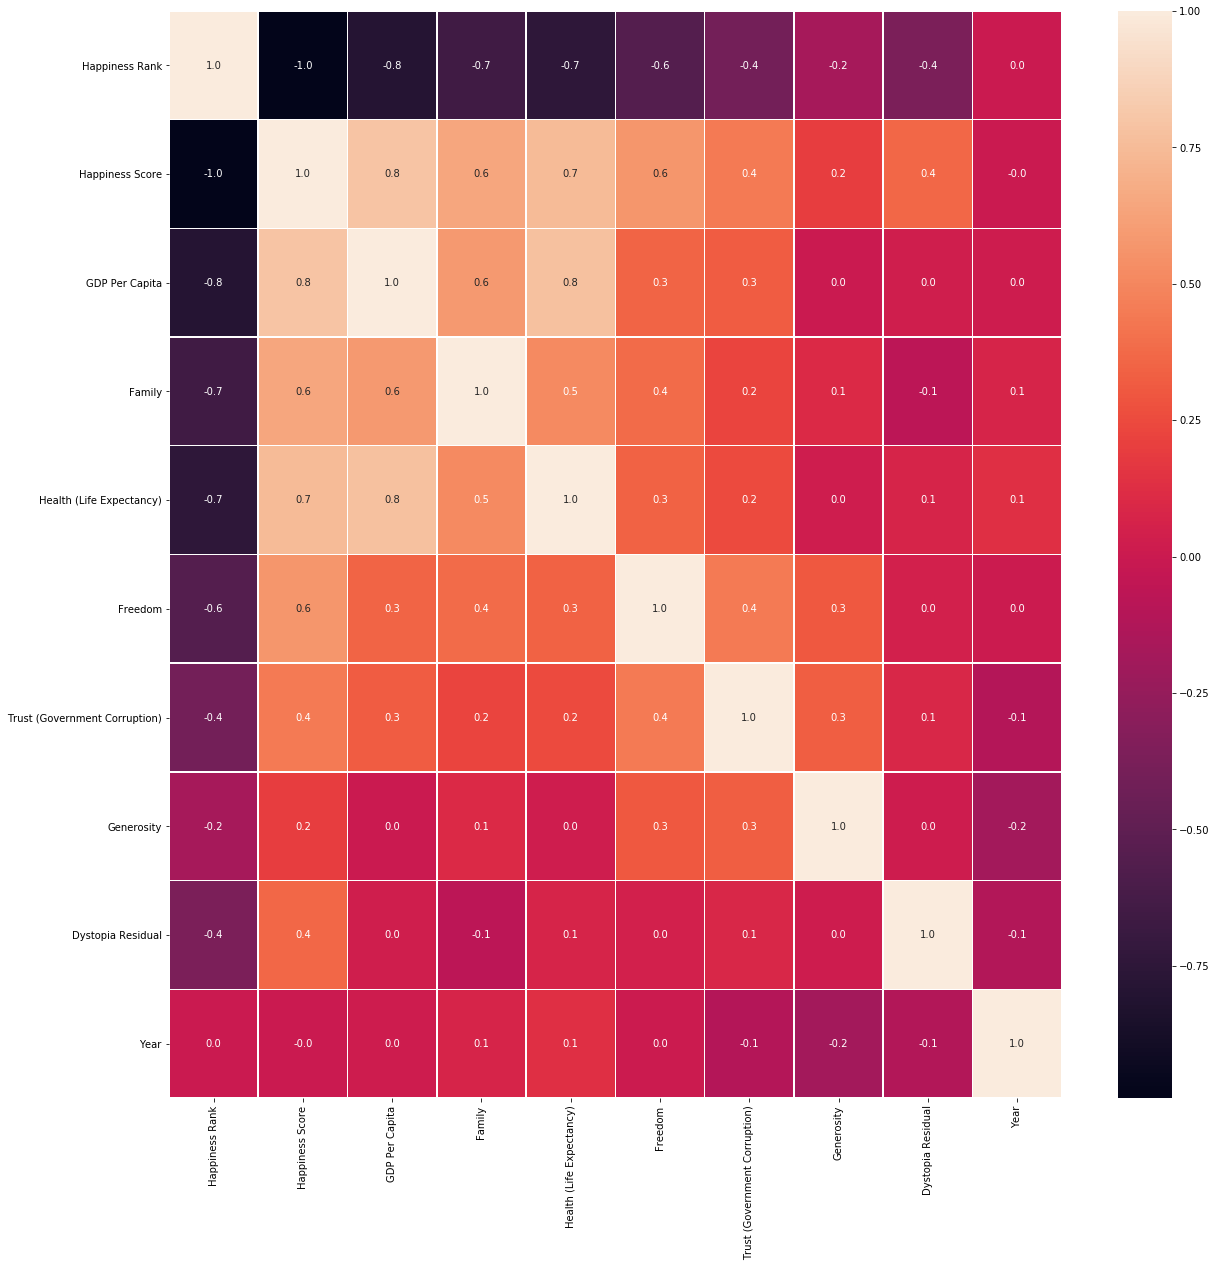

In [4]:
# LOOKING AT CORRELATIONS 
corr=DF.corr()
corr
f,ax=plt.subplots(figsize=(20,20))
sns.heatmap(corr,annot=True,linewidths=.5,fmt='.1f',ax=ax)
plt.show()

# Year | Dystopia Residual | Generosity == Little correlations 
# Country == Region Meaning similar 

In [5]:

X = pd.get_dummies(DF[[ 'Region', 'Happiness Rank',
       'GDP Per Capita', 'Family','Health (Life Expectancy)','Freedom',
       'Trust (Government Corruption)', ]]).to_numpy()

Y = np.array(DF['Happiness Score'])



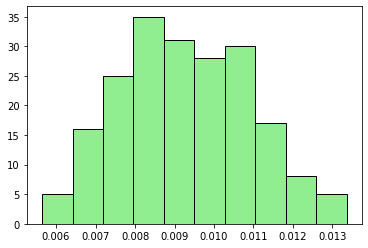

In [6]:

def train_test(X,Y,method):
    mse=[]
    for i in range(200):
        xtrain,xtest,ytrain,ytest=train_test_split(X,Y)
        method.fit(xtrain,ytrain)
        YP=method.predict(xtest)
        mse.append(mean_squared_error(ytest,YP))
    return mse
SVRmethod =SVR()
mse = train_test(X,Y,SVRmethod)
plt.hist(mse,edgecolor="black",color="lightgreen");

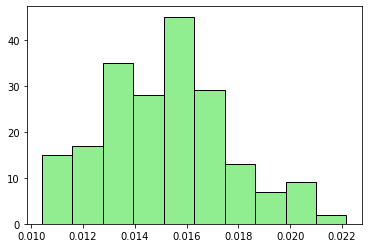

In [7]:
mse = train_test(X,Y,LR())
plt.hist(mse,edgecolor="black",color="lightgreen");

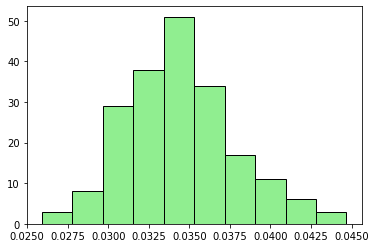

In [8]:
from sklearn.tree import DecisionTreeRegressor

mse = train_test(X,Y,DecisionTreeRegressor(max_depth=3))
plt.hist(mse,edgecolor="black",color="lightgreen");

In [9]:
from sklearn.metrics import confusion_matrix
method = SVR()
xtrain,xtest,ytrain,ytest=train_test_split(X,Y)
method.fit(xtrain,ytrain)
YP=method.predict(xtest)


In [10]:
DF2019 = DF[DF['Year']==2019]
DF2018 =  DF[DF['Year']==2018]
DF2017 =  DF[DF['Year']==2017]
DF2016 =  DF[DF['Year']==2016]
DF2015 =  DF[DF['Year']==2015]

In [11]:
# DF2019= DF2019.drop(columns =['Dystopia Residual','Country','Year'])
# DF2019

In [12]:
# Y2019=np.array(DF2019['Happiness Score'])
# X2019=pd.get_dummies(DF2019[['Region','Happiness Rank','GDP Per Capita',
#                        'Health (Life Expectancy)','Freedom','Trust (Government Corruption)','Generosity']]).to_numpy()


In [13]:

# method = SVR()

# mse=[]
# for i in range(50):
#     xtrain,xtest,ytrain,ytest=train_test_split(X2019,Y2019)
#     method.fit(xtrain,ytrain)
#     YP=method.predict(xtest)
#     mse.append(mean_squared_error(ytest,YP))

# plt.hist(mse,edgecolor="black",color="lightgreen")

In [14]:
DF.describe()

,Happiness Rank,Happiness Score,GDP Per Capita,Family,Health (Life Expectancy),Freedom,Trust (Government Corruption),Generosity,Dystopia Residual,Year
count,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000
mean,78.079167,5.397312,0.919052,0.999890,0.615211,0.407882,0.118525,0.210500,2.107826,2017.040278
std,44.314442,1.098405,0.399073,0.252005,0.245798,0.152305,0.095306,0.113816,0.374561,1.429781
min,1.000000,2.853000,0.000000,0.192490,0.000000,0.000000,0.000000,0.000000,0.899910,2015.000000
25%,40.000000,4.534750,0.617727,0.791847,0.449894,0.306963,0.053998,0.125750,2.000090,2016.000000
50%,79.000000,5.322000,0.982705,1.036715,0.651505,0.429540,0.089000,0.197000,2.092243,2017.000000
75%,116.000000,6.168000,1.234561,1.172210,0.809181,0.525250,0.149812,0.266624,2.200617,2018.000000
max,157.000000,7.769000,2.096000,1.610574,1.122000,0.724000,0.439299,0.576300,3.351680,2019.000000


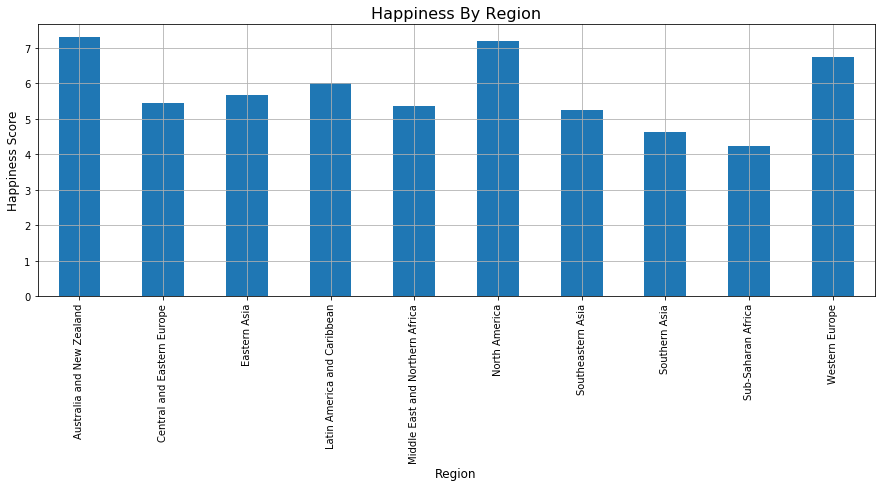

In [15]:
RegionGrouped = DF.groupby('Region')['Happiness Score'].mean()
RegionGrouped.plot.bar()
plt.title("Happiness By Region", fontsize = 16)
plt.ylabel("Happiness Score", fontsize = 12)
plt.xlabel("Region",fontsize = 12)
plt.gcf().set_size_inches(15,5)
plt.grid();


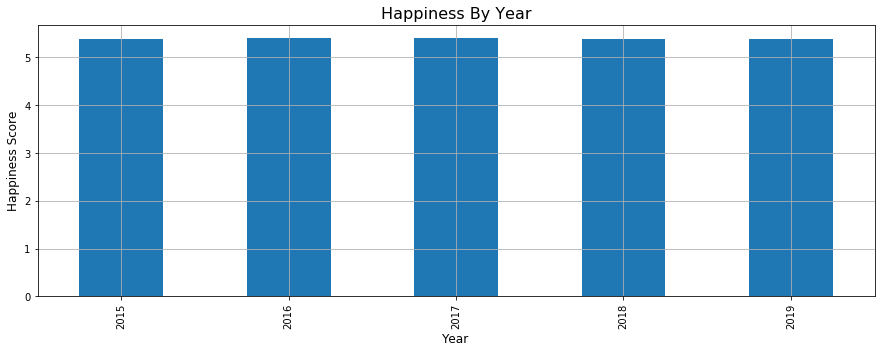

In [16]:
YearGrouped = DF.groupby('Year')['Happiness Score'].mean()
YearGrouped.plot.bar()
plt.title("Happiness By Year", fontsize = 16)
plt.ylabel("Happiness Score", fontsize = 12)
plt.xlabel("Year",fontsize = 12)
plt.gcf().set_size_inches(15,5)
plt.grid();